In [1]:
import tensorflow as tf
%pylab inline
import pickle

import itertools
import os
import pandas as pd

import networkx as nx
import umap
from scipy import stats

# %env CUDA_VISIBLE_DEVICES=0

Populating the interactive namespace from numpy and matplotlib


In [2]:
tf.config.threading.set_intra_op_parallelism_threads(24)
tf.config.threading.set_inter_op_parallelism_threads(24)

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#     # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#         print(e)

In [4]:
import hosgns_walks
from utils import *

In [15]:
# preprocess dataset
dataset = 'OpenABM-Covid19-Interactions-5k-20'
AGGR_TIME = 1
partial_times, s_temp_net, df_tnet = load_temp_data(dataset, AGGR_TIME)

In [16]:
# rename nodes and time slices
map_node_index = {node:index for index, node in \
                  enumerate(np.unique(s_temp_net.reset_index()[['i', 'j']].values.flatten()))}
map_time_index = {time:index for index, time in \
                  enumerate(np.unique(s_temp_net.reset_index().tslice.values))}
NR_NODES = len(map_node_index)
NR_TIMES = len(map_time_index)

df_tnet['tslice'] = df_tnet['tslice'].map(map_time_index) 
df_tnet['i'] = df_tnet['i'].map(map_node_index) 
df_tnet['j'] = df_tnet['j'].map(map_node_index)

In [17]:
# load network and default list of active nodes
supra_G = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/Stat/Aggtime%d.gpickle' % (dataset, AGGR_TIME), 'rb'))
pat_active_time = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/PatActiveTimeAggtime%d.pkl'% (dataset,AGGR_TIME), 'rb'))
node_active_time = np.array([str(map_node_index[int(n_node.split('-')[0])])+'-'+\
                                 str(map_time_index[int(n_node.split('-')[1])]) for n_node in pat_active_time])
times = [int(x.split('-')[1]) for x in node_active_time]
node_tuple_time = [(int(n_node.split('-')[0]), int(n_node.split('-')[1])) for n_node in node_active_time]

In [18]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import cartesian

# TENSOR FACTORIZATION of 3WAY P(Stat)

In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
# train 3way-hosgns 
print_every=200
solver = hosgns_walks.HOSGNSSolver(network=supra_G.to_undirected(), 
                         window_size=1,
                         emb_dim=128,
                         order=3,
                         iters=4000,
                         batch_size=20000, 
                         negative_samples=5,
                         learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(0.05, 4000),
                         warmup_steps=1000,
                         random_state=42)
loss = solver.train(print_loss='sg', print_every=print_every)
emb_W, emb_T, emb_C = solver.model.factors

#save embeddings
# pickle.dump(list(solver.model.factors), open( '../output/%s_Stat_Aggtime%dWindow%dWay%s.pkl' % (dataset, AGGR_TIME, 1, '3Redu'), "wb" ), protocol=pickle.HIGHEST_PROTOCOL)

Sampling Random Walks...
Warmup...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Training...
step    0 - loss: 0.4505593478679657 (26.5536 seconds)
step  200 - loss: 0.23769976198673248 (38.2648 seconds)
step  400 - loss: 0.195443794131279 (39.0625 seconds)
step  600 - loss: 0.1774454265832901 (38.5544 seconds)
step  800 - loss: 0.16678138077259064 (38.7622 seconds)
step 1000 - loss: 0.15928062796592712 (38.9199 seconds)
step 1200 - loss: 0.15361125767230988 (36.0006 seconds)
step 1400 - loss: 0.14907245337963104 (38.1222 seconds)
step 1600 - loss: 0.14525440335273743 (39.3366 seconds)
step 1800 - loss: 0.14200319349765778 (37.8488 seconds)
step 2000 - loss: 0.13908013701438904 (38.8870 seconds)
step 2200 - loss: 0.1364922672510147 (36.8351 seconds)
step 2400 - loss: 0.13410311937332153 (36.0536 seconds)
step 2600 - loss: 0.13187317550182343 (38.5140 seconds)
step 2800 - loss: 0.1298067271709442

In [20]:
#load embeddings
emb_W, emb_T, emb_C = pickle.load(open( '../output/%s_Stat_Aggtime%dWindow%dWay%s.pkl' % (dataset, AGGR_TIME, 1, '3Redu'), "rb") )

Text(0.5, 1.0, '$ -\\sum_{ijk}[ p_{ijk} \\log \\sigma (m_{ijk}) + \\kappa p_ip_jp_k \\log \\sigma (-m_{ijk})]$')

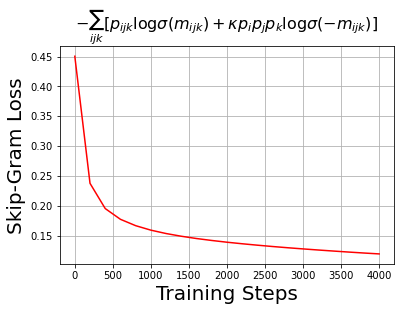

In [11]:
# plot hosgns loss function 

plt.plot(np.arange(len(loss['sg']))*print_every, np.array([t for t in loss['sg']]) ,'r')
plt.grid()
plt.xlabel("Training Steps", fontsize=20)
plt.ylabel("Skip-Gram Loss", fontsize=20)
plt.title(r'$ -\sum_{ijk}[ p_{ijk} \log \sigma (m_{ijk}) + \kappa p_ip_jp_k \log \sigma (-m_{ijk})]$', fontsize=16)

## Node Classification

In [23]:
y = get_infection_label('SIR', 0.125, 0.001, pat_active_time, dataset, AGGR_TIME)
nc_res=[]
for train_test_dict in make_train_test_splits_NC(y, n_splits=30, starting_test_size=0.3, \
                       node_active_list=node_tuple_time, random_state=100):
    emb1_train_idx, emb2_train_idx, y_train_idx = train_test_dict['train']
    emb1_test_idx, emb2_test_idx, y_test_idx = train_test_dict['test']
    
    X_train = emb_W.numpy()[emb1_train_idx]*emb_T.numpy()[emb2_train_idx]
    X_test = emb_W.numpy()[emb1_test_idx]*emb_T.numpy()[emb2_test_idx]
    y_train = y[y_train_idx]
    y_test = y[y_test_idx]
    
    model_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=6, random_state=100))
    y_test_pred = model_clf.fit(X_train, y_train).predict(X_test)
    nc_res.append(f1_score(y_test, y_test_pred, average='macro'))
print('F1_macro:', np.mean(nc_res), '+-', np.std(nc_res))

F1_macro: 0.2734977768190634 +- 0.0786175050511122


## Link Reconstruction

In [21]:
lr_res=[]
for train_test_dict in make_train_test_splits_LR(n_splits=6, starting_test_size=0.3, \
                       node_active_list=node_tuple_time, df_events=df_tnet, random_state=100):
    emb1_train_idx, emb2_train_idx, emb3_train_idx, y_train = train_test_dict['train']
    emb1_test_idx, emb2_test_idx, emb3_test_idx, y_test = train_test_dict['test']
    X_train = emb_W.numpy()[emb1_train_idx]*emb_C.numpy()[emb2_train_idx]*emb_T.numpy()[emb3_train_idx]
    X_test = emb_W.numpy()[emb1_test_idx]*emb_C.numpy()[emb2_test_idx]*emb_T.numpy()[emb3_test_idx]
    
    model_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=6, random_state=100))
    y_test_pred = model_clf.fit(X_train, y_train).predict(X_test)
    lr_res.append(f1_score(y_test, y_test_pred, average='macro'))
print('F1_macro:', np.mean(lr_res), '+-', np.std(lr_res))

F1_macro: 0.9692040426786029 +- 0.001010137601193648


## Link Prediction

In [10]:
# load network and default list of active nodes
supra_G = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/Stat/Aggtime%d.gpickle' % (dataset+'_7030_0', AGGR_TIME), 'rb'))
pat_active_time = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/PatActiveTimeAggtime%d.pkl'% (dataset,AGGR_TIME), 'rb'))
node_active_time = np.array([str(map_node_index[int(n_node.split('-')[0])])+'-'+\
                                 str(map_time_index[int(n_node.split('-')[1])]) for n_node in pat_active_time])
times = [int(x.split('-')[1]) for x in node_active_time]
node_tuple_time = [(int(n_node.split('-')[0]), int(n_node.split('-')[1])) for n_node in node_active_time]

In [11]:
# train 3way-hosgns 
print_every=200
solver = hosgns_walks.HOSGNSSolver(network=supra_G.to_undirected(), 
                         window_size=1,
                         emb_dim=128,
                         order=3,
                         iters=4000,
                         batch_size=20000, 
                         negative_samples=5,
                         learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(0.05, 4000),
                         warmup_steps=1000,
                         random_state=42)
loss = solver.train(print_loss='sg', print_every=print_every)
emb_W, emb_T, emb_C = solver.model.factors

Sampling Random Walks...
Warmup...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Training...
step    0 - loss: 0.4505690336227417 (30.1117 seconds)
step  200 - loss: 0.23258444666862488 (41.1394 seconds)
step  400 - loss: 0.1846439242362976 (40.0483 seconds)
step  600 - loss: 0.1638634353876114 (39.6710 seconds)
step  800 - loss: 0.15133948624134064 (40.2470 seconds)
step 1000 - loss: 0.1426786631345749 (39.7366 seconds)
step 1200 - loss: 0.13608315587043762 (39.3542 seconds)
step 1400 - loss: 0.13077765703201294 (39.7787 seconds)
step 1600 - loss: 0.1263435333967209 (41.9091 seconds)
step 1800 - loss: 0.12250664085149765 (40.8170 seconds)
step 2000 - loss: 0.11914383620023727 (38.5123 seconds)
step 2200 - loss: 0.11615611612796783 (39.8880 seconds)
step 2400 - loss: 0.11339296400547028 (37.7264 seconds)
step 2600 - loss: 0.11082945764064789 (37.1695 seconds)
step 2800 - loss: 0.108466237783432 

In [12]:
_, _, df_tnet = load_temp_data(dataset, aggr_time=AGGR_TIME)
_, _, df_samp = load_modified_temp_data(dataset, aggr_time=AGGR_TIME)
df_del = df_tnet.loc[df_tnet.merge(df_samp, on=['tslice','i','j'], how='left', suffixes=('','_')).weight_.isnull()].reset_index(drop=True)

df_samp['tslice'] = df_samp['tslice'].map(map_time_index) 
df_samp['i'] = df_samp['i'].map(map_node_index) 
df_samp['j'] = df_samp['j'].map(map_node_index)

df_del['tslice'] = df_del['tslice'].map(map_time_index) 
df_del['i'] = df_del['i'].map(map_node_index) 
df_del['j'] = df_del['j'].map(map_node_index)

In [14]:
df_events = (df_samp, df_del)

lp_res=[]
for train_test_dict in make_train_test_splits_LP(n_splits=6, starting_test_size=0.3, \
                       node_active_list=node_tuple_time, df_events=df_events, random_state=100):
    emb1_train_idx, emb2_train_idx, emb3_train_idx, y_train = train_test_dict['train']
    emb1_test_idx, emb2_test_idx, emb3_test_idx, y_test = train_test_dict['test']
    X_train = emb_W.numpy()[emb1_train_idx]*emb_C.numpy()[emb2_train_idx]*emb_T.numpy()[emb3_train_idx]
    X_test = emb_W.numpy()[emb1_test_idx]*emb_C.numpy()[emb2_test_idx]*emb_T.numpy()[emb3_test_idx]
    
    model_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=6, random_state=100))
    y_test_pred = model_clf.fit(X_train, y_train).predict(X_test)
    lp_res.append(f1_score(y_test, y_test_pred, average='macro'))
print('F1_macro:', np.mean(lp_res), '+-', np.std(lp_res))

F1_macro: 0.8668545036426405 +- 0.00548866640495443
